# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry. 

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

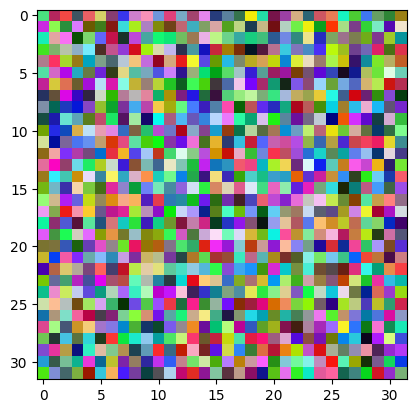

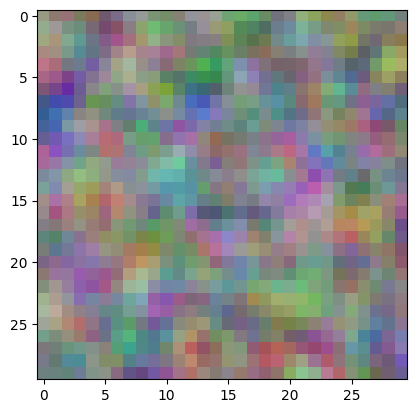

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

tensor = torch.rand((1, 3, 32, 32))

size = 3

channel_connections = torch.eye(size)

filter = torch.tensor([[0.1, 0.1, 0.1], [0.1, 0.2, 0.1], [0.1, 0.1, 0.1]])

blur = channel_connections.view(size, size, 1, 1) * filter

plt.imshow(tensor[0].permute(1, 2, 0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor, blur)

plt.imshow(blurred[0].permute(1, 2, 0))
plt.show()

# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie 

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


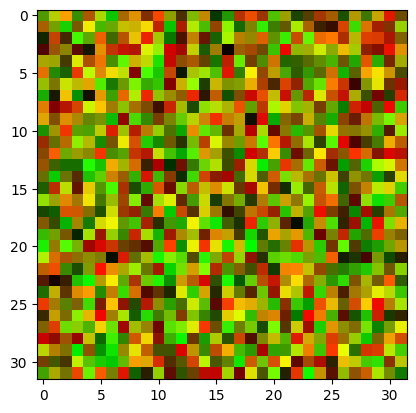

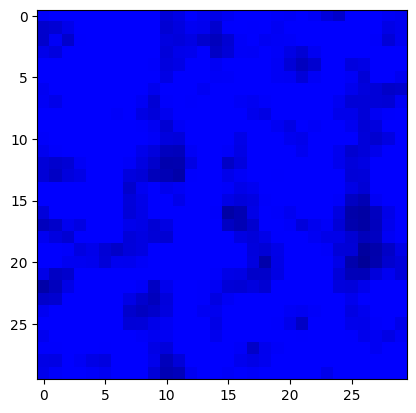

In [5]:
tensor = torch.rand((10, 3, 32, 32))
tensor[:, 2] = -7

filter = torch.tensor([[0.1, 0.1, 0.1], [0.1, 0.2, 0.1], [0.1, 0.1, 0.1]])

rg_blur_to_b = torch.zeros((3, 3, 3, 3))


rg_blur_to_b[2, 0] = filter  # R
rg_blur_to_b[2, 1] = filter  # G

blurred = torch.nn.functional.conv2d(tensor, rg_blur_to_b)

plt.imshow(tensor[0].permute(1, 2, 0))
plt.show()

plt.imshow(blurred[0].permute(1, 2, 0))
plt.show()

# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

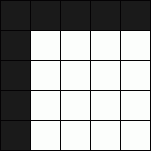

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

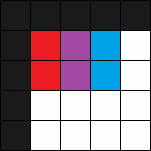
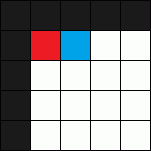


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [6]:
data_batch = torch.zeros(10, 16, 32, 32)

# deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16, 32, 2)

conv_layer(data_batch).shape

torch.Size([10, 32, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak: 

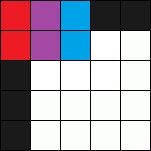

In [7]:
data_batch = torch.zeros(10, 16, 32, 32)

conv_layer = torch.nn.Conv2d(16, 16, 2, padding=1)
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16, 16, 3, padding=1)
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

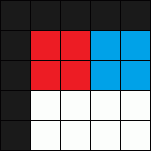


In [8]:
data_batch = torch.zeros(10, 16, 32, 32)
conv_layer = torch.nn.Conv2d(16, 16, 2, stride=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

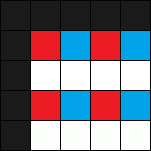

In [9]:
data_batch = torch.zeros(10, 16, 32, 32)
conv_layer = torch.nn.Conv2d(16, 16, 2, dilation=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

#Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [10]:
pool_layer = torch.nn.MaxPool2d(2)  # okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2, 4))  # pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10, 3, 128, 128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(
    data_batch
).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling. 

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [33]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, download=True
)
test_ds = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, train=False, download=True
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
from sklearn.metrics import f1_score


def f_score(model: nn.Module, dataloader: DataLoader) -> float:
    all_preds = []
    all_true = []
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.numpy())

    return f1_score(all_true, all_preds, average="weighted")

In [46]:
def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def validate(
    model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: bool = True,
):
    f1_scores = []

    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        if print_metrics:
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )

                val_f1 = f_score(model, val_dl)
                f1_scores.append(val_f1)

                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f}, f1: {val_f1:.3f})"
                )
    return f1_scores

Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3. 

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [39]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, channels: int, labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module(
            "conv_1", torch.nn.Conv2d(3, channels, kernel_size=3, stride=1, padding=1)
        )
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("max_pool", torch.nn.MaxPool2d(2))
        self.model.add_module(
            "conv_2", torch.nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1)
        )
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(64 * 16 * 16, labels))

    def forward(self, x):
        return self.model(x)

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [40]:
cnn_model = SimpleCNN(16, 10)
out = cnn_model(torch.zeros(128, 3, 32, 32))
assert out.shape == (128, 10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

28.2 ms ± 575 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.01 ms ± 2.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [41]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

100%|██████████| 1563/1563 [00:11<00:00, 141.99it/s]


Epoch 0: train loss = 0.034 (acc: 0.625), validation loss = 0.036 (acc: 0.594, f1: 0.595)


100%|██████████| 1563/1563 [00:11<00:00, 135.12it/s]


Epoch 1: train loss = 0.028 (acc: 0.688), validation loss = 0.032 (acc: 0.643, f1: 0.644)


100%|██████████| 1563/1563 [00:12<00:00, 122.95it/s]


Epoch 2: train loss = 0.025 (acc: 0.729), validation loss = 0.030 (acc: 0.666, f1: 0.660)


100%|██████████| 1563/1563 [00:12<00:00, 130.10it/s]


Epoch 3: train loss = 0.022 (acc: 0.764), validation loss = 0.029 (acc: 0.674, f1: 0.669)


100%|██████████| 1563/1563 [00:11<00:00, 136.71it/s]


Epoch 4: train loss = 0.019 (acc: 0.797), validation loss = 0.029 (acc: 0.683, f1: 0.685)


# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [15]:
class CNN(nn.Module):
    def __init__(self, num_labels, filter_size, num_channels, downsampling_type):
        super(CNN, self).__init__()

        downsampling_rate = 2
        num_conv_layers = len(num_channels)
        self.in_conv = nn.Conv2d(3, num_channels[0], kernel_size=1)

        conv_layers = []
        for i in range(num_conv_layers - 1):
            conv_layers.append(
                nn.Conv2d(
                    num_channels[i],
                    num_channels[i + 1],
                    kernel_size=filter_size,
                    padding=filter_size // 2,
                )
            )
            if downsampling_type == "pooling":
                conv_layers.append(nn.MaxPool2d(downsampling_rate))
            elif downsampling_type == "conv":
                conv_layers.append(
                    nn.Conv2d(
                        num_channels[i + 1],
                        num_channels[i + 1],
                        kernel_size=downsampling_rate,
                        stride=downsampling_rate,
                    )
                )

        self.conv_layers = nn.Sequential(*conv_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(num_channels[-1], num_labels)

    def forward(self, x):
        x = self.in_conv(x)
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = torch.squeeze(x)
        x = self.fc(x)
        return x

Zweryfikuj działanie implementacji:

In [16]:
dummy_data = torch.zeros(37, 3, 32, 32)

# utwórz CNN z: 15 etykietami wyjściowymi, filtrem 5x5, 3 warstwy conv z liczbą kanałów: 16,32,64, downsampling warstwą konwolucyjną
cnn_model = CNN(15, 5, [16, 32, 64], "conv")
assert cnn_model(dummy_data).shape == (37, 15)

# utwórz CNN: 10 etykiet wyjściowych, filtr 3x3, 4 warstwy conv z liczbą kanałów: 8,16,32,64, downsampling warstwą poolingu
cnn_model = CNN(10, 3, [8, 16, 32, 64], "pooling")
assert cnn_model(dummy_data).shape == (37, 10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

28.2 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.02 ms ± 66.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [57]:
import matplotlib.pyplot as plt


def plot_f1_scores(f1_scores: list[tuple[list[float], str]]):
    plt.figure(figsize=(10, 6))
    lines = []
    for f1_score, label in f1_scores:
        (line,) = plt.plot(f1_score, label=label)
        lines.append(line)
    plt.title("F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.legend(lines, [l.get_label() for l in lines], loc="best")
    plt.show()

In [48]:
f1_all_scores = []

Uczenie z filtrem 3x3 a 5x5

100%|██████████| 1563/1563 [00:11<00:00, 135.13it/s]


Epoch 0: train loss = 0.057 (acc: 0.331), validation loss = 0.057 (acc: 0.342, f1: 0.343)


100%|██████████| 1563/1563 [00:11<00:00, 131.23it/s]


Epoch 1: train loss = 0.052 (acc: 0.400), validation loss = 0.052 (acc: 0.402, f1: 0.395)


100%|██████████| 1563/1563 [00:12<00:00, 124.37it/s]


Epoch 2: train loss = 0.049 (acc: 0.441), validation loss = 0.049 (acc: 0.438, f1: 0.413)


100%|██████████| 1563/1563 [00:11<00:00, 135.87it/s]


Epoch 3: train loss = 0.047 (acc: 0.462), validation loss = 0.047 (acc: 0.463, f1: 0.462)


100%|██████████| 1563/1563 [00:11<00:00, 139.53it/s]


Epoch 4: train loss = 0.045 (acc: 0.485), validation loss = 0.046 (acc: 0.480, f1: 0.477)


100%|██████████| 1563/1563 [00:11<00:00, 132.19it/s]


Epoch 0: train loss = 0.053 (acc: 0.383), validation loss = 0.053 (acc: 0.391, f1: 0.368)


100%|██████████| 1563/1563 [00:11<00:00, 130.62it/s]


Epoch 1: train loss = 0.049 (acc: 0.442), validation loss = 0.048 (acc: 0.441, f1: 0.414)


100%|██████████| 1563/1563 [00:12<00:00, 130.17it/s]


Epoch 2: train loss = 0.044 (acc: 0.507), validation loss = 0.044 (acc: 0.498, f1: 0.486)


100%|██████████| 1563/1563 [00:12<00:00, 130.03it/s]


Epoch 3: train loss = 0.041 (acc: 0.543), validation loss = 0.041 (acc: 0.537, f1: 0.534)


100%|██████████| 1563/1563 [00:11<00:00, 131.02it/s]


Epoch 4: train loss = 0.040 (acc: 0.547), validation loss = 0.041 (acc: 0.535, f1: 0.531)


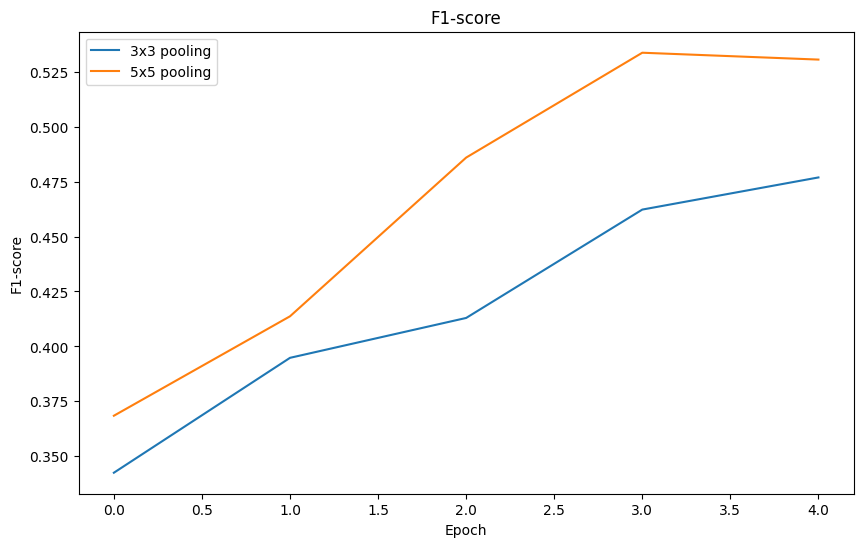

In [58]:
cnn_model1 = CNN(15, 3, [16, 32, 64], "pooling").cuda()
optimizer1 = optim.Adam(cnn_model1.parameters())
loss_fn1 = torch.nn.CrossEntropyLoss()
f1_scores1 = fit(cnn_model1, optimizer1, loss_fn1, train_dl, test_dl, 5, True)
f1_all_scores.append((f1_scores1, "3x3 pooling"))

cnn_model2 = CNN(15, 5, [16, 32, 64], "pooling").cuda()
optimizer2 = optim.Adam(cnn_model2.parameters())
loss_fn2 = torch.nn.CrossEntropyLoss()
f1_scores2 = fit(cnn_model2, optimizer2, loss_fn2, train_dl, test_dl, 5, True)
f1_all_scores.append((f1_scores2, "5x5 pooling"))

plot_f1_scores([(f1_scores1, "3x3 pooling"), (f1_scores2, "5x5 pooling")])

Uczenie z Max Pooling a warstwą konwolucją do downsamplingu

100%|██████████| 1563/1563 [00:12<00:00, 128.74it/s]


Epoch 0: train loss = 0.061 (acc: 0.296), validation loss = 0.061 (acc: 0.304, f1: 0.276)


100%|██████████| 1563/1563 [00:12<00:00, 125.61it/s]


Epoch 1: train loss = 0.059 (acc: 0.340), validation loss = 0.059 (acc: 0.344, f1: 0.336)


100%|██████████| 1563/1563 [00:12<00:00, 127.67it/s]


Epoch 2: train loss = 0.059 (acc: 0.326), validation loss = 0.059 (acc: 0.328, f1: 0.316)


100%|██████████| 1563/1563 [00:12<00:00, 126.37it/s]


Epoch 3: train loss = 0.059 (acc: 0.339), validation loss = 0.059 (acc: 0.339, f1: 0.333)


100%|██████████| 1563/1563 [00:12<00:00, 126.20it/s]


Epoch 4: train loss = 0.059 (acc: 0.343), validation loss = 0.059 (acc: 0.340, f1: 0.330)


100%|██████████| 1563/1563 [00:12<00:00, 127.84it/s]


Epoch 0: train loss = 0.053 (acc: 0.386), validation loss = 0.052 (acc: 0.389, f1: 0.366)


100%|██████████| 1563/1563 [00:12<00:00, 129.83it/s]


Epoch 1: train loss = 0.047 (acc: 0.463), validation loss = 0.047 (acc: 0.463, f1: 0.453)


100%|██████████| 1563/1563 [00:11<00:00, 131.06it/s]


Epoch 2: train loss = 0.044 (acc: 0.490), validation loss = 0.045 (acc: 0.478, f1: 0.465)


100%|██████████| 1563/1563 [00:11<00:00, 133.21it/s]


Epoch 3: train loss = 0.042 (acc: 0.524), validation loss = 0.042 (acc: 0.514, f1: 0.509)


100%|██████████| 1563/1563 [00:11<00:00, 132.58it/s]


Epoch 4: train loss = 0.041 (acc: 0.535), validation loss = 0.042 (acc: 0.527, f1: 0.510)


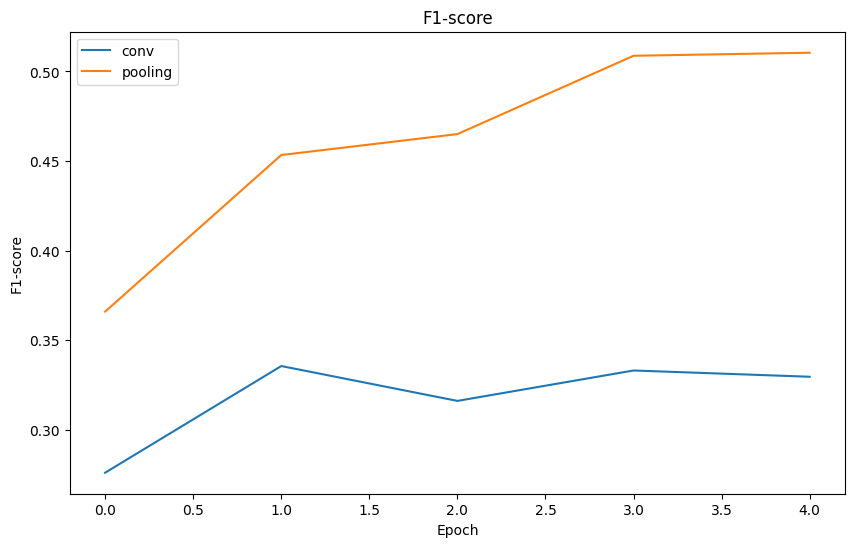

In [59]:
cnn_model3 = CNN(15, 5, [16, 32, 64], "conv").cuda()
optimizer3 = optim.Adam(cnn_model3.parameters())
loss_fn3 = torch.nn.CrossEntropyLoss()
f1_scores3 = fit(cnn_model3, optimizer3, loss_fn3, train_dl, test_dl, 5, True)
f1_all_scores.append((f1_scores3, "conv"))

cnn_model4 = CNN(15, 5, [16, 32, 64], "pooling").cuda()
optimizer4 = optim.Adam(cnn_model4.parameters())
loss_fn4 = torch.nn.CrossEntropyLoss()
f1_scores4 = fit(cnn_model4, optimizer4, loss_fn4, train_dl, test_dl, 5, True)
f1_all_scores.append((f1_scores4, "pooling"))

plot_f1_scores([(f1_scores3, "conv"), (f1_scores4, "pooling")])

Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

100%|██████████| 1563/1563 [00:11<00:00, 131.72it/s]


Epoch 0: train loss = 0.053 (acc: 0.352), validation loss = 0.053 (acc: 0.357, f1: 0.339)


100%|██████████| 1563/1563 [00:11<00:00, 132.84it/s]


Epoch 1: train loss = 0.049 (acc: 0.431), validation loss = 0.049 (acc: 0.433, f1: 0.423)


100%|██████████| 1563/1563 [00:12<00:00, 129.23it/s]


Epoch 2: train loss = 0.044 (acc: 0.504), validation loss = 0.045 (acc: 0.495, f1: 0.492)


100%|██████████| 1563/1563 [00:12<00:00, 128.61it/s]


Epoch 3: train loss = 0.043 (acc: 0.512), validation loss = 0.044 (acc: 0.504, f1: 0.488)


100%|██████████| 1563/1563 [00:12<00:00, 128.92it/s]


Epoch 4: train loss = 0.040 (acc: 0.547), validation loss = 0.041 (acc: 0.541, f1: 0.532)


100%|██████████| 1563/1563 [00:12<00:00, 126.53it/s]


Epoch 0: train loss = 0.052 (acc: 0.391), validation loss = 0.052 (acc: 0.395, f1: 0.385)


100%|██████████| 1563/1563 [00:12<00:00, 127.86it/s]


Epoch 1: train loss = 0.048 (acc: 0.458), validation loss = 0.048 (acc: 0.457, f1: 0.440)


100%|██████████| 1563/1563 [00:12<00:00, 129.45it/s]


Epoch 2: train loss = 0.044 (acc: 0.498), validation loss = 0.044 (acc: 0.494, f1: 0.483)


100%|██████████| 1563/1563 [00:12<00:00, 129.35it/s]


Epoch 3: train loss = 0.043 (acc: 0.514), validation loss = 0.043 (acc: 0.507, f1: 0.492)


100%|██████████| 1563/1563 [00:12<00:00, 127.61it/s]


Epoch 4: train loss = 0.040 (acc: 0.545), validation loss = 0.041 (acc: 0.534, f1: 0.528)


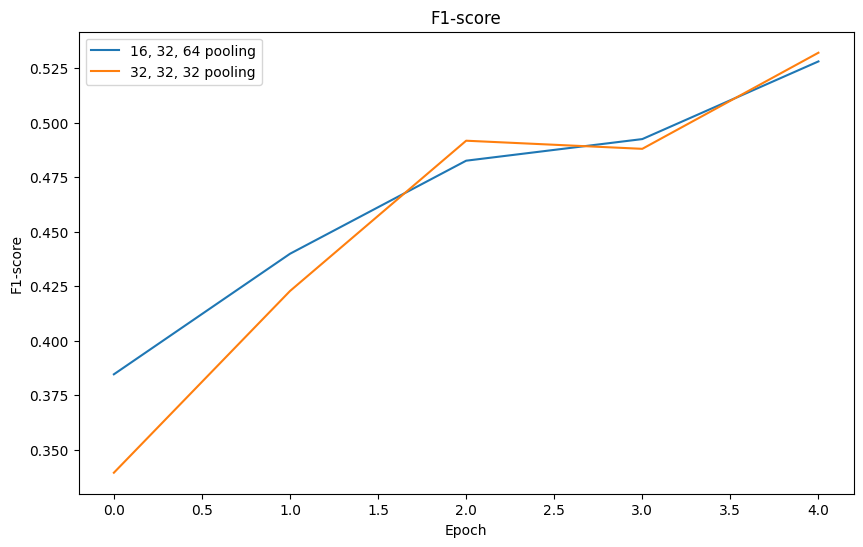

In [60]:
cnn_model5 = CNN(15, 5, [16, 32, 64], "pooling").cuda()
optimizer5 = optim.Adam(cnn_model5.parameters())
loss_fn5 = torch.nn.CrossEntropyLoss()
f1_scores5 = fit(cnn_model5, optimizer5, loss_fn5, train_dl, test_dl, 5, True)
f1_all_scores.append((f1_scores5, "16, 32, 64 pooling"))

cnn_model6 = CNN(15, 5, [32, 32, 32], "pooling").cuda()
optimizer6 = optim.Adam(cnn_model6.parameters())
loss_fn6 = torch.nn.CrossEntropyLoss()
f1_scores6 = fit(cnn_model6, optimizer6, loss_fn6, train_dl, test_dl, 5, True)
f1_all_scores.append((f1_scores6, "32, 32, 32 pooling"))

plot_f1_scores([(f1_scores6, "16, 32, 64 pooling"), (f1_scores5, "32, 32, 32 pooling")])

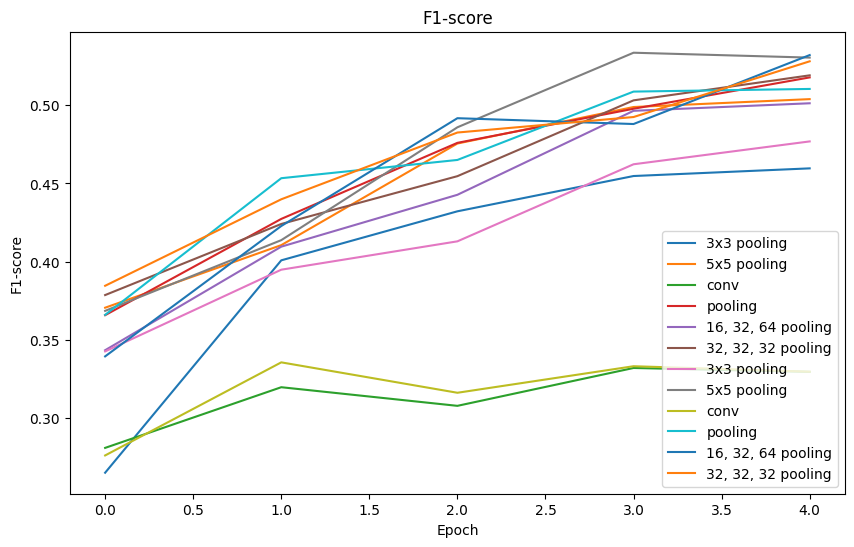

In [61]:
plot_f1_scores(f1_all_scores)